In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.circuit.library import ZGate, XGate
from qiskit import execute, Aer
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from pylab import *

In [2]:
def hsgs(N, vector):
    
    circuit = QuantumCircuit(N)
    
    phase = -1
    target_phase = phase
    
    # get the number of ones in each state
    vector_n_ones = get_number_of_ones(N)
    
    all_states_in_binary = get_all_states_in_binary(N)
    
    #print(vector)
    
    #print('::::::: case -|00...00>')
    # case: phase on |0> state, i.e.: -|00...00>
    if vector[0] == target_phase:
        # add Z gate to all qubits, we will have the phase in state |0> plus a global phase equal to -1
        circuit.z(range(N))
        # then the target phase should be inverted (due to the global phase of -1)
        target_phase *= phase
        # update other affected states
        for j in range(len(vector)):
            vector[j] *= phase**vector_n_ones[j]
        #print('updated because -|00...00>:', vector)
        # factor out a -1
        #vector *= phase
        #print('factor out a -1:', vector)
    
    
    #print('::::::: case only one |1>')
    # case: states with only one |1> in any qubit
    indices_with_one_1 = np.where(vector_n_ones == 1)[0]
    for j in indices_with_one_1:
        if vector[j] == target_phase:  # need a phase, then add a Z gate
            #print(all_states_in_binary[j])
            #qubit = np.where(np.flip(all_states_in_binary[j]) == 1)[0]
            qubit = np.where(all_states_in_binary[j] == 1)[0]
            #print('qubit =', qubit)
            circuit.z(N-1-qubit) # inverse order due to Qiskit order: |q1q0>
            # update other affected states
            update_other_phases(vector, all_states_in_binary, qubit, j, phase)
            #print(vector)
            
    
    #print('::::::: case p = 2, ..., N')
    # case: p = 2, ..., N
    for p in range(2, N+1):
        #print('p =',p)
        multiConrolledZ = ZGate().control(num_ctrl_qubits=p-1)
        indices_with_p_1s = np.where(vector_n_ones == p)[0]
        for j in indices_with_p_1s:
            if vector[j] == target_phase:  # need a phase, then add a C^pZ gate
                #print(all_states_in_binary[j])
                qubits = np.where(all_states_in_binary[j] == 1)[0]
                #print('qubits =', qubits)
                # inverse order due to Qiskit order: |q1q0>
                qubits_inverted = np.where(np.flip(all_states_in_binary[j]) == 1)[0]
                circuit.append(multiConrolledZ, list(qubits_inverted))
                # update other affected states
                update_other_phases(vector, all_states_in_binary, qubits, j, phase)
                #print(vector)
    
    return circuit

In [3]:
def get_binary_vector(N, k):
    convert_phases = lambda j: (-1)**j
    bitstring_array = np.array(list(format(k, '0'+str(2**N)+'b')), dtype=int)
    vfunc = np.vectorize(convert_phases)
    return vfunc(bitstring_array)

def get_number_of_ones(N):
    return np.array([n.bit_count() for n in range(2**N)])

def get_all_states_in_binary(N):
    return np.array([np.array(list(format(n, '0'+str(N)+'b')), dtype=int) for n in range(2**N)])

def update_other_phases(vector, all_states_in_binary, affected_qubits, j, phase):
    #print('affected_qubits =', affected_qubits)
    for i in range(j, len(vector)):
        #print('all_states_in_binary[',i,'] =', all_states_in_binary[i])
        #print('np.where(all_states_in_binary[',i,']==1)[0] =', np.where(all_states_in_binary[i]==1)[0])
        if all([elem in np.where(all_states_in_binary[i] == 1)[0] for elem in affected_qubits]):
            #print('entro a cambiar el vector')
            vector[i] *= phase
            #print(vector)

In [4]:
def U_i(N, ki, circuit):
    
    # create equal superposition
    circuit.h(range(N))
    
    # get vector i given the value ki
    vector_i = get_binary_vector(N, ki)
    
    # execute hsgs
    circuit.compose(hsgs(N, vector_i), inplace=True)

def U_w(N, kw, circuit):
    
    # get vector w given the value kw
    vector_w = get_binary_vector(N, kw)
    
    # execute hsgs
    circuit.compose(hsgs(N, vector_w), inplace=True)
    
    # apply Hadamards
    circuit.h(range(N))
    
    # apply NOTs
    circuit.x(range(N))

In [5]:
def perceptron_optimized(N, ki, kw, draw=False):
    
    # create circuit, N qubits + ancilla
    circuit = QuantumCircuit(N + 1, 1)
    
    # apply U_i
    U_i(N, ki, circuit)
    
    # apply U_w
    U_w(N, kw, circuit)
    
    # apply C^N X
    circuit.mcx(control_qubits=[i for i in range(N)], target_qubit=N)
    
    # measure the ancilla qubit
    circuit.measure(N, 0)
    
    # draw circuit
    if draw == True:
        display(circuit.draw('mpl'))
    
    return circuit

In [6]:
def draw_image(N, k):
        
    ns = format(k, '0'+str(2**N)+'b')
    
    fig, ax = plt.subplots(figsize=(2, 2))
        
    ax.grid(which='both', axis='both', linestyle='-', color='black', linewidth=1)

    cmap = colors.ListedColormap(['white', 'black'])

    ax.set_xticks(np.arange(0.5, N, 1));
    ax.set_yticks(np.arange(0.5, N, 1));
    plt.tick_params(axis='both', which='both', bottom=False,   
                    left=False, labelbottom=False, labelleft=False)
    
    image_data = np.zeros((N, N))
    j = 0
    for (x,y), _ in np.ndenumerate(image_data):
        image_data[x][y] = int(ns[j])
        j += 1
    
    ax.imshow(image_data, cmap=cmap)
    
    plt.show()

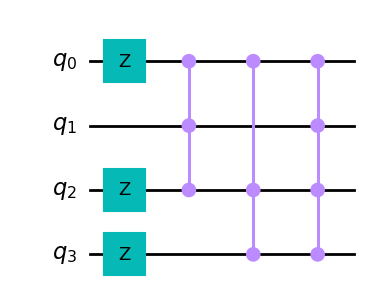

In [7]:
cir = hsgs(4, get_binary_vector(4, 23456))#32768))#49152))# 14336))
cir.draw('mpl')

In [8]:
def validate_hsgs(N, k):
    
    print('         k =', k)
    
    vector = get_binary_vector(N, k)
    print('    vector =', vector)
    
    circuit = QuantumCircuit(N)
    circuit.h(range(N)) # equal superposition of all states
    
    circuit.compose(hsgs(N, vector.copy()), inplace=True)
    
    psi = Statevector(circuit)
    print('  psi.data =', psi.data)
    
    if vector[0] == -1:
        vector *= -1
    
    if all([int(sign(psi.data[i].real)) == vector[i] for i in range(len(vector))]):
        print('✔️ State represented correctly\n')

In [9]:
validate_hsgs(4, 49152)
validate_hsgs(4, 14336)
validate_hsgs(4, 32768)
validate_hsgs(4, 65535)

         k = 49152
    vector = [-1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
  psi.data = [ 0.25+0.j  0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j
 -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j
 -0.25+0.j -0.25+0.j]
✔️ State represented correctly

         k = 14336
    vector = [ 1  1 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1]
  psi.data = [ 0.25+0.j  0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j  0.25+0.j  0.25+0.j
  0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j  0.25+0.j
  0.25+0.j  0.25+0.j]
✔️ State represented correctly

         k = 32768
    vector = [-1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1]
  psi.data = [ 0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j
 -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j -0.25+0.j
 -0.25+0.j -0.25+0.j]
✔️ State represented correctly

         k = 65535
    vector = [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  psi.data = [0.25+0.j 0.25+0.j 0.25+0.j 0.25

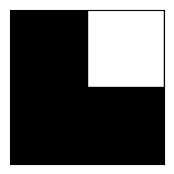

In [10]:
draw_image(N=2, k=11)

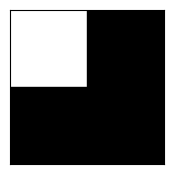

In [11]:
draw_image(N=2, k=7)

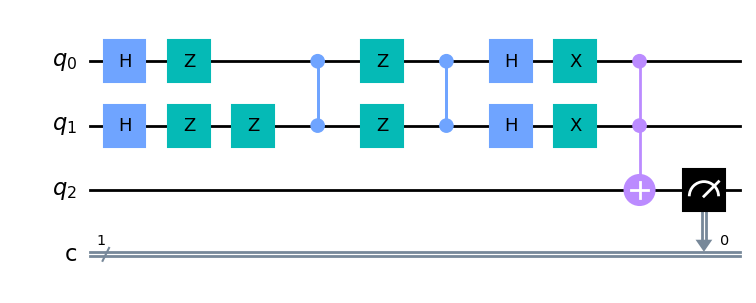

In [12]:
perceptron_circuit = perceptron_optimized(N=2, ki=11, kw=7, draw=True) # same as circuit in Fig 3c

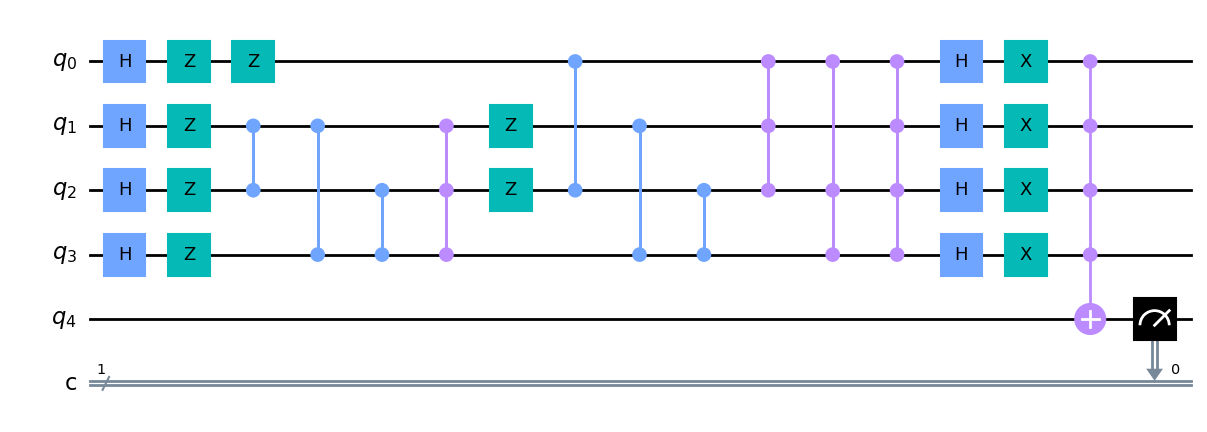

In [13]:
perceptron_circuit_big = perceptron_optimized(N=4, ki=49152, kw=14336, draw=True) # same as circuit in Fig 2

In [14]:
simulator = Aer.get_backend('aer_simulator')

job = execute(perceptron_circuit, simulator, shots=1000)
counts = job.result().get_counts(perceptron_circuit)
print(counts)                                           # always 0, perceptron not activated

#plot_histogram(counts, title='Perceptron simulation with U_i and U_w in brute force')

{'0': 1000}


In [15]:
# code from: https://stackoverflow.com/a/43119180/713780

def make_bar(ax, x0=0, y0=0, width = 0.5, height=1 , cmap="viridis",  
              norm=matplotlib.colors.Normalize(vmin=0, vmax=1), **kwargs ):
    # Make data
    u = np.linspace(0, 2*np.pi, 4+1)+np.pi/4.
    v_ = np.linspace(np.pi/4., 3./4*np.pi, 100)
    v = np.linspace(0, np.pi, len(v_)+2 )
    v[0] = 0 ;  v[-1] = np.pi; v[1:-1] = v_
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    xthr = np.sin(np.pi/4.)**2 ;  zthr = np.sin(np.pi/4.)
    x[x > xthr] = xthr; x[x < -xthr] = -xthr
    y[y > xthr] = xthr; y[y < -xthr] = -xthr
    z[z > zthr] = zthr  ; z[z < -zthr] = -zthr

    x *= 1./xthr*width; y *= 1./xthr*width
    z += zthr
    z *= height/(2.*zthr)
    #translate
    x += x0; y += y0
    #plot
    ax.plot_surface(x, y, z, cmap=cmap, norm=norm, **kwargs)

def make_bars(ax, x, y, height, width=1):
    widths = np.array(width)*np.ones_like(x)
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    h = np.array(height).flatten()
    w = np.array(widths).flatten()
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1) #, vmax=h.max())
    for i in range(len(x.flatten())):
        make_bar(ax, x0=x[i], y0=y[i], width = w[i] , height=h[i], norm=norm)


In [16]:
# Calculate for every value for ki and kw

N = 2
shots = 1000

results_sim = []
for kw in range(2**(2**N)):
    results_sim.append([])
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_optimized(N, ki, kw)
        job = execute(perceptron_circuit, simulator, shots=shots)
        counts = job.result().get_counts(perceptron_circuit)
        if '1' in counts: results_sim[kw].append(counts['1']/shots)
        else: results_sim[kw].append(0)

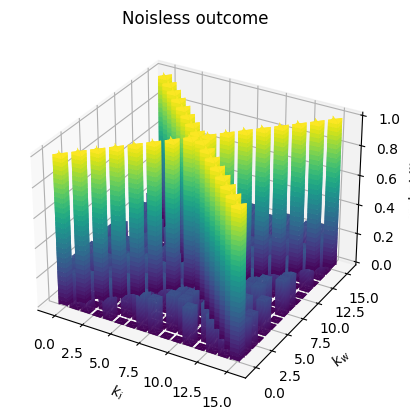

In [17]:
data_array = np.array(results_sim) # Convert it into an numpy array


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

make_bars(ax, x_data, y_data, z_data, width=0.4)

ax.set_title("Noisless outcome")
ax.set_xlabel('$k_i$')
ax.set_ylabel('$k_w$')
ax.set_zlabel('probability')

plt.show()

In [18]:
from qiskit import IBMQ

#IBMQ.save_account('TOKEN')

IBMQ.load_account()

IBMQ.providers() 

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-community', group='ibmquantumawards', project='open-science-22')>,
 <AccountProvider for IBMQ(hub='qc-fall-22-5', group='group-1', project='recmcZjyMk2obFy9z')>]

In [19]:
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_manila') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_nairobi') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibm_oslo') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [20]:
from qiskit.providers.ibmq import least_busy

devices = provider.backends(simulator=False, operational=True)

least_busy_device = least_busy(devices)

In [21]:
least_busy_device

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

In [22]:
least_busy_device.configuration().n_qubits

5

In [23]:
# Calculate for every value for ki and kw

N = 2
shots = 1000

results = []
for kw in range(2**(2**N)):
    results.append([])
    for ki in range(2**(2**N)):
        perceptron_circuit = perceptron_optimized(N, ki, kw)
        circuit_transpiled = transpile(perceptron_circuit, least_busy_device) # in this case the transpilation is necessary

        job = least_busy_device.run(circuit_transpiled, shots=shots)
        
        counts = job.result().get_counts()
        if '1' in counts: results[kw].append(counts['1']/shots)
        else: results[kw].append(0)

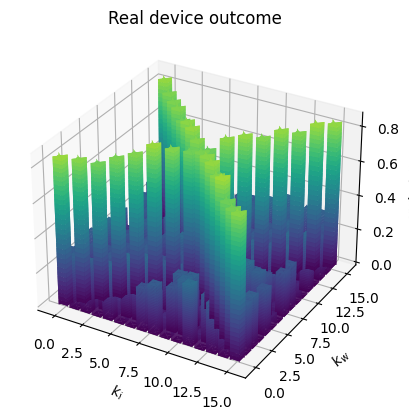

In [38]:
data_array = np.array(results) # Convert it into an numpy array


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                              np.arange(data_array.shape[0]) )

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = data_array.flatten()

make_bars(ax, x_data, y_data, z_data, width=0.4)

ax.set_title("Real device outcome")
ax.set_xlabel('$k_i$')
ax.set_ylabel('$k_w$')
ax.set_zlabel('probability')

plt.show()

In [25]:
# save data 'cause take approx 2.5 hours to run on the cloud device
with open("results_ibmq_belem_optimized_Ui_Uw.txt", "w") as file:
    file.write(str(results))

In [37]:
#with open("results_ibmq_belem_optimized_Ui_Uw.txt", "r") as file:
#    results = eval(file.readline())

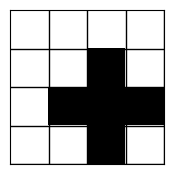

In [27]:
# weight vector for example for N=4 (Fig 4)
draw_image(N=4, k=626)

In [28]:
# examples as in Fig 4

kis = [624, 64941, 578, 64925, 49224, 15871, 37120, 34882]

kw = 626

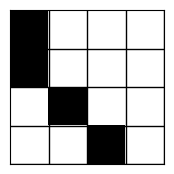

In [29]:
# show example 
draw_image(N=4, k=kis[7])

In [32]:
def get_probability_of_activation(N, ki, kw):
    perceptron_circuit = perceptron_optimized(N=N, ki=ki, kw=kw)
    shots = 10000
    job = execute(perceptron_circuit, simulator, shots=shots)
    counts = job.result().get_counts(perceptron_circuit)
    if '1' in counts: return counts['1']/shots
    else: return 0

q.alg.opt. = 0.7662


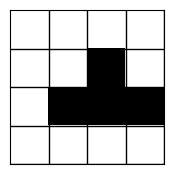

q.alg.opt. = 0.7703


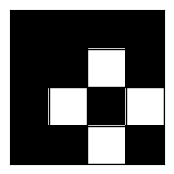

q.alg.opt. = 0.5626


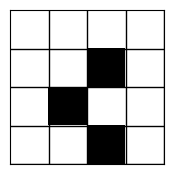

q.alg.opt. = 0.7663


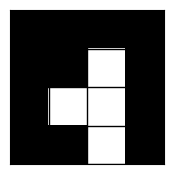

q.alg.opt. = 0.0153


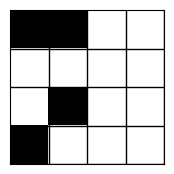

q.alg.opt. = 0.0628


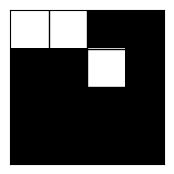

q.alg.opt. = 0


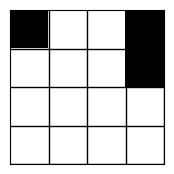

q.alg.opt. = 0.1385


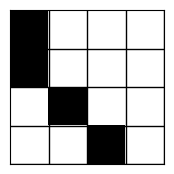

In [46]:
N=4
for ki in kis:
    prob = get_probability_of_activation(N, ki, kw)
    print("q.alg.opt. =", prob)
    draw_image(N=N, k=ki)

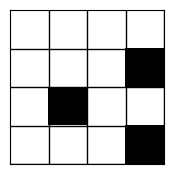

In [52]:
draw_image(N=4, k=321)